In [2]:
import stim
import pymatching
import numpy as np

In [3]:
# code from https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

circuit = stim.Circuit.generated("repetition_code:memory", rounds=1, distance=9, before_round_data_depolarization=0.15)
num_shots = 100_000
num_logical_errors = count_logical_errors(circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 89 wrong predictions (logical errors) out of 100000 shots


## Testing this method on the 5-qubit code

In [88]:
def init_circuit():
    circuit = stim.Circuit()
    # Adding qubit coordinates metadata
    print("Initialization complete.")
    return circuit

def encode(circuit):
    # Encoding step: Measuring X and Z stabilizers
    circuit += stim.Circuit("""

        MPP X0*Z1*Z2*X3
        MPP X1*Z2*Z3*X4
        MPP X0*X2*Z3*Z4
        MPP Z0*X1*X3*Z4
    """)
    print("Encoding complete.")

def channel(circuit, error_rate, noisy_qubits=list(range(5))):
    # Noise channel: Adding X errors with probability 0 (for testing, can be adjusted)
    circuit.append("TICK")
    circuit.append("X_ERROR", noisy_qubits, error_rate)  # 10% error probability for demonstration
    circuit.append("TICK")
    print("Noise channel applied.")

def error_correction(circuit):
    # Error correction: Measuring the stabilizers again
    circuit += stim.Circuit("""
        MPP X0*Z1*Z2*X3
        MPP X1*Z2*Z3*X4
        MPP X0*X2*Z3*Z4
        MPP Z0*X1*X3*Z4
    """)
    # TODO we extracted the syndromes but didn't correct errors.

    # Adding detectors for error syndrome extraction
    circuit += stim.Circuit("""
        DETECTOR rec[-4] rec[-8]
        DETECTOR rec[-3] rec[-7]
        DETECTOR rec[-2] rec[-6]
        DETECTOR rec[-1] rec[-5]
    """)

    circuit += stim.Circuit("""
        # Logical Z operator for the 5-qubit code
        MPP Z0*Z1*Z2*Z3*Z4
        OBSERVABLE_INCLUDE(0) rec[-1]

        # Logical X operator for the 5-qubit code
        # MPP X0*X1*X2*X3*X4
        # OBSERVABLE_INCLUDE(1) rec[-1]
    """)
    print("Error correction complete.")

In [89]:

# Initialize the circuit
circuit = init_circuit()

# Encode the logical qubit
encode(circuit)

# Apply noise channel
channel(circuit, 0.3, [0,1,2,3,4])

# Perform error correction
error_correction(circuit)

# Print the final circuit for verification
print(circuit)

Initialization complete.
Encoding complete.
Noise channel applied.
Error correction complete.
MPP X0*Z1*Z2*X3 X1*Z2*Z3*X4 X0*X2*Z3*Z4 Z0*X1*X3*Z4
TICK
X_ERROR(0.3) 0 1 2 3 4
TICK
MPP X0*Z1*Z2*X3 X1*Z2*Z3*X4 X0*X2*Z3*Z4 Z0*X1*X3*Z4
DETECTOR rec[-4] rec[-8]
DETECTOR rec[-3] rec[-7]
DETECTOR rec[-2] rec[-6]
DETECTOR rec[-1] rec[-5]
MPP Z0*Z1*Z2*Z3*Z4
OBSERVABLE_INCLUDE(0) rec[-1]


In [90]:
circuit.compile_detector_sampler().sample(shots=10)

array([[ True, False,  True,  True],
       [ True, False, False, False],
       [False, False, False, False],
       [ True, False,  True, False],
       [False,  True, False,  True],
       [False, False,  True,  True],
       [ True, False, False, False],
       [False, False,  True,  True],
       [ True, False, False, False],
       [False, False, False, False]])

In [91]:
num_shots = 100_000
num_logical_errors = count_logical_errors(circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 16266 wrong predictions (logical errors) out of 100000 shots


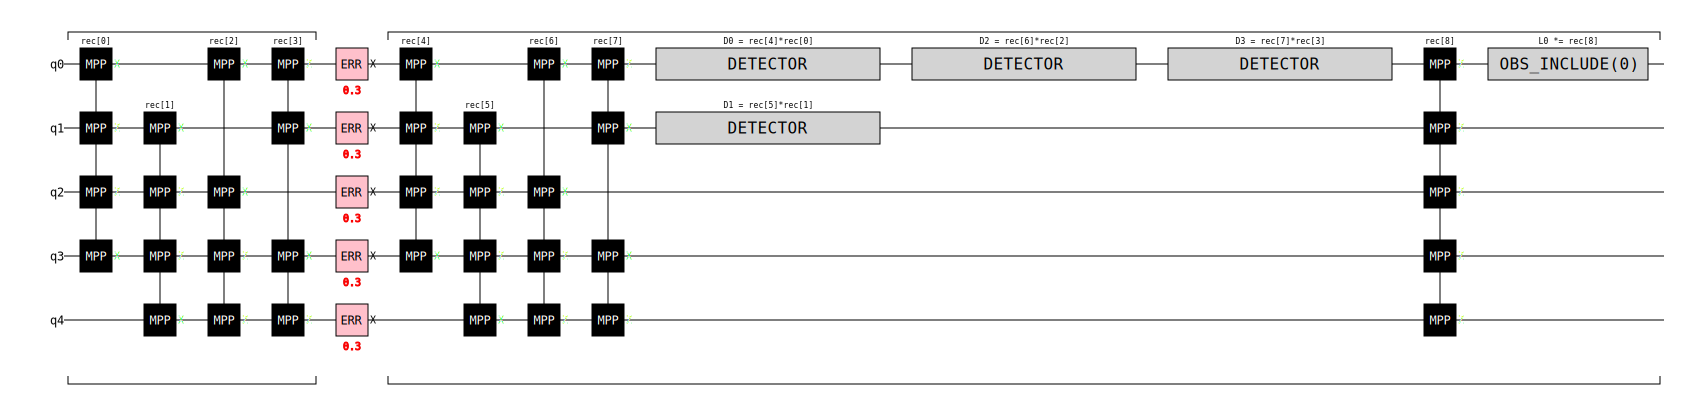

In [92]:
circuit.diagram('timeline-svg')

In [29]:
circuit.to_crumble_url()

'https://algassert.com/crumble#circuit=MPP_X0*Z1*Z2*X3_X1*Z2*Z3*X4_X0*X2*Z3*Z4_Z0*X1*X3*Z4_X0*Z1*Z2*X3_X1*Z2*Z3*X4_X0*X2*Z3*Z4_Z0*X1*X3*Z4_X0*Z1*Z2*X3_X1*Z2*Z3*X4_X0*X2*Z3*Z4_Z0*X1*X3*Z4_X0*Z1*Z2*X3_X1*Z2*Z3*X4_X0*X2*Z3*Z4_Z0*X1*X3*Z4;DT_rec[-4]_rec[-8];DT_rec[-3]_rec[-7];DT_rec[-2]_rec[-6];DT_rec[-1]_rec[-5];MPP_Z0*X2*X3;OI(0)rec[-1]'